In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook
import circulation_plots

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [70]:
def plot_velocity_boxes(dirname, dicts, case):

    fname = "1_MCKNZ_1h_20170101_201701*"
    fig, axes = plt.subplots(len(dicts)+2, 3, figsize=(21, 27),
                             gridspec_kw={"width_ratios":[1.2, 1, 3.5],
                                          "height_ratios":[0.5, 0.01, 1, 1, 1, 1, 1, 1, 1, 1]})
    fig.tight_layout(w_pad=0.5, h_pad=0.2)

    for n, ttl in zip(np.arange(3), ['Top view', 'Side view', 'u-velocity component [$ms^{-1}$]']):
        ax = axes[1, n]
        ax.axis("off")
        ax.set_title(ttl, fontsize=20)
        
    # ---------------------------------------------------------------------
        
    axes[0, 0].remove()
    axes[0, 1].remove()
    sozotaux = quicklook.get_sozotaux(dirname, fname)
    axw = axes[0, 2]
    axw.plot(sozotaux, c='k', lw=2)
    axw.set_ylim([-1.7, 0.1])
    axw.set_xlim([0, 10*24])
    axw.xaxis.set_ticks(np.arange(0, 10*24, 24))
    axw.grid()
    axw.set_title('Wind Stress [$Nm^{-2}$]', fontsize=20)
    
    # ---------------------------------------------------------------------
    
    for m, dict_plot in zip(np.arange(2, len(dicts)+2), dicts):
        
        x_starts = dict_plot['x_startsEW']
        x_ends = dict_plot['x_endsEW']
        y_start = dict_plot['y_start']
        y_end = dict_plot['y_end']
        dep_start = dict_plot['dep_start']
        dep_end = dict_plot['dep_end']
        
        cs = ['mediumvioletred', 'steelblue']
        labs = ['upstream', 'downstream']
        
        ax1 = axes[m, 0]; ax2 = axes[m, 1]; ax3 = axes[m, 2]

        for x_start, x_end, c, lab in zip(x_starts, x_ends, cs, labs):
            
            vozocrtx, umask, umask_all, depthu, e1u, e2u,\
                sozotaux = quicklook.get_vars_for_box(dirname, fname, x_start, x_end, y_start, y_end)
                
            avgU_all_ys, avgU_all_depths, avgU_box_depths,\
                avgU_absolute = quicklook.calculate_avgU(vozocrtx, dep_start, dep_end)

            cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])
            xs = np.arange(umask_all.shape[-1])
            ys = np.arange(umask_all.shape[-2])
            zs = depthu

            # ---------------------------------------------------------------------

            ax1.pcolormesh(xs, ys, umask_all[dep_end, :,:], cmap=cmap)
            ax1.add_patch(patches.Rectangle((x_start, y_start), (x_end-x_start),(y_end-y_start),
                                            ec=c, fill=False, lw=3))
            ax1.set_aspect(aspect='equal')
            ax1.set_xlim([0, xs[-1]])
            ax1.set_ylim([0, ys[-1]])
            labels_x = ax1.get_xticks().tolist()
            labels_y = ax1.get_yticks().tolist()
            ticks_x = [int(np.round(lab*np.mean(e1u)/1000)) for lab in labels_x]
            ticks_y = [int(np.round(lab*np.mean(e2u)/1000)) for lab in labels_y]
            ax1.set_xticklabels(ticks_x)
            ax1.set_yticklabels(ticks_y)
            ax1.yaxis.grid(True)
            
            # ---------------------------------------------------------------------

            sc = ax2.pcolormesh(ys, zs, umask_all[:, :, int((x_starts[1]+x_ends[1])/2)], cmap=cmap)
            ax2.add_patch(patches.Rectangle((y_start, depthu[dep_start]),(y_end-y_start), depthu[dep_end]-depthu[dep_start],
                                            ec=cs[1], fill=False, lw=2))
            ax2.set_ylim([zs[-1], 0])
            ax2.set_xlim([0, ys[-1]])
            ax2.set_xticklabels(ticks_y)
            ax2.grid()
            
            # ---------------------------------------------------------------------

            avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
            ax3.plot(avgU_absolute[:], c='dimgray', lw=2, alpha=0.8)
            ax3.plot(avgU_absolute_smoothed, c=c, lw=2.5, label=lab)
            ax3.set_ylim([-0.6, 0.1])
            ax3.set_xlim([0, 10*24])
            ax3.xaxis.set_ticks(np.arange(0, 10*24, 24))
            ax3.legend(ncol=2, loc=4, fontsize=20)
        ax3.grid()
            
    # ---------------------------------------------------------------------

    plt.subplots_adjust(top=0.95)
    fig.suptitle(case+' - u-velocity at varios depths on up/downstream sides of canyon', fontsize=30)
        
    return fig

# Indices

In [71]:
x_startE, x_startW = 200, 30
x_endsE, x_endsW = 230, 60 

In [82]:
dict_1 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':2, 'dep_end':6}

dict_2 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':7, 'dep_end':11}

dict_3 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':12, 'dep_end':16}

dict_4 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':25, 'dep_end':30}

dict_5 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':40, 'dep_end':45}

dict_6 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':190, 'dep_start':65, 'dep_end':68}

dict_7 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':195, 'dep_start':70, 'dep_end':73}

dict_8 = {'x_startsEW':[x_startE, x_startW], 'x_endsEW':[x_endsE, x_endsW], 'y_start':45, 'y_end':200, 'dep_start':75, 'dep_end':78}

dicts =  [dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7, dict_8]

# Ideal

In [83]:
flag = 'ideal'

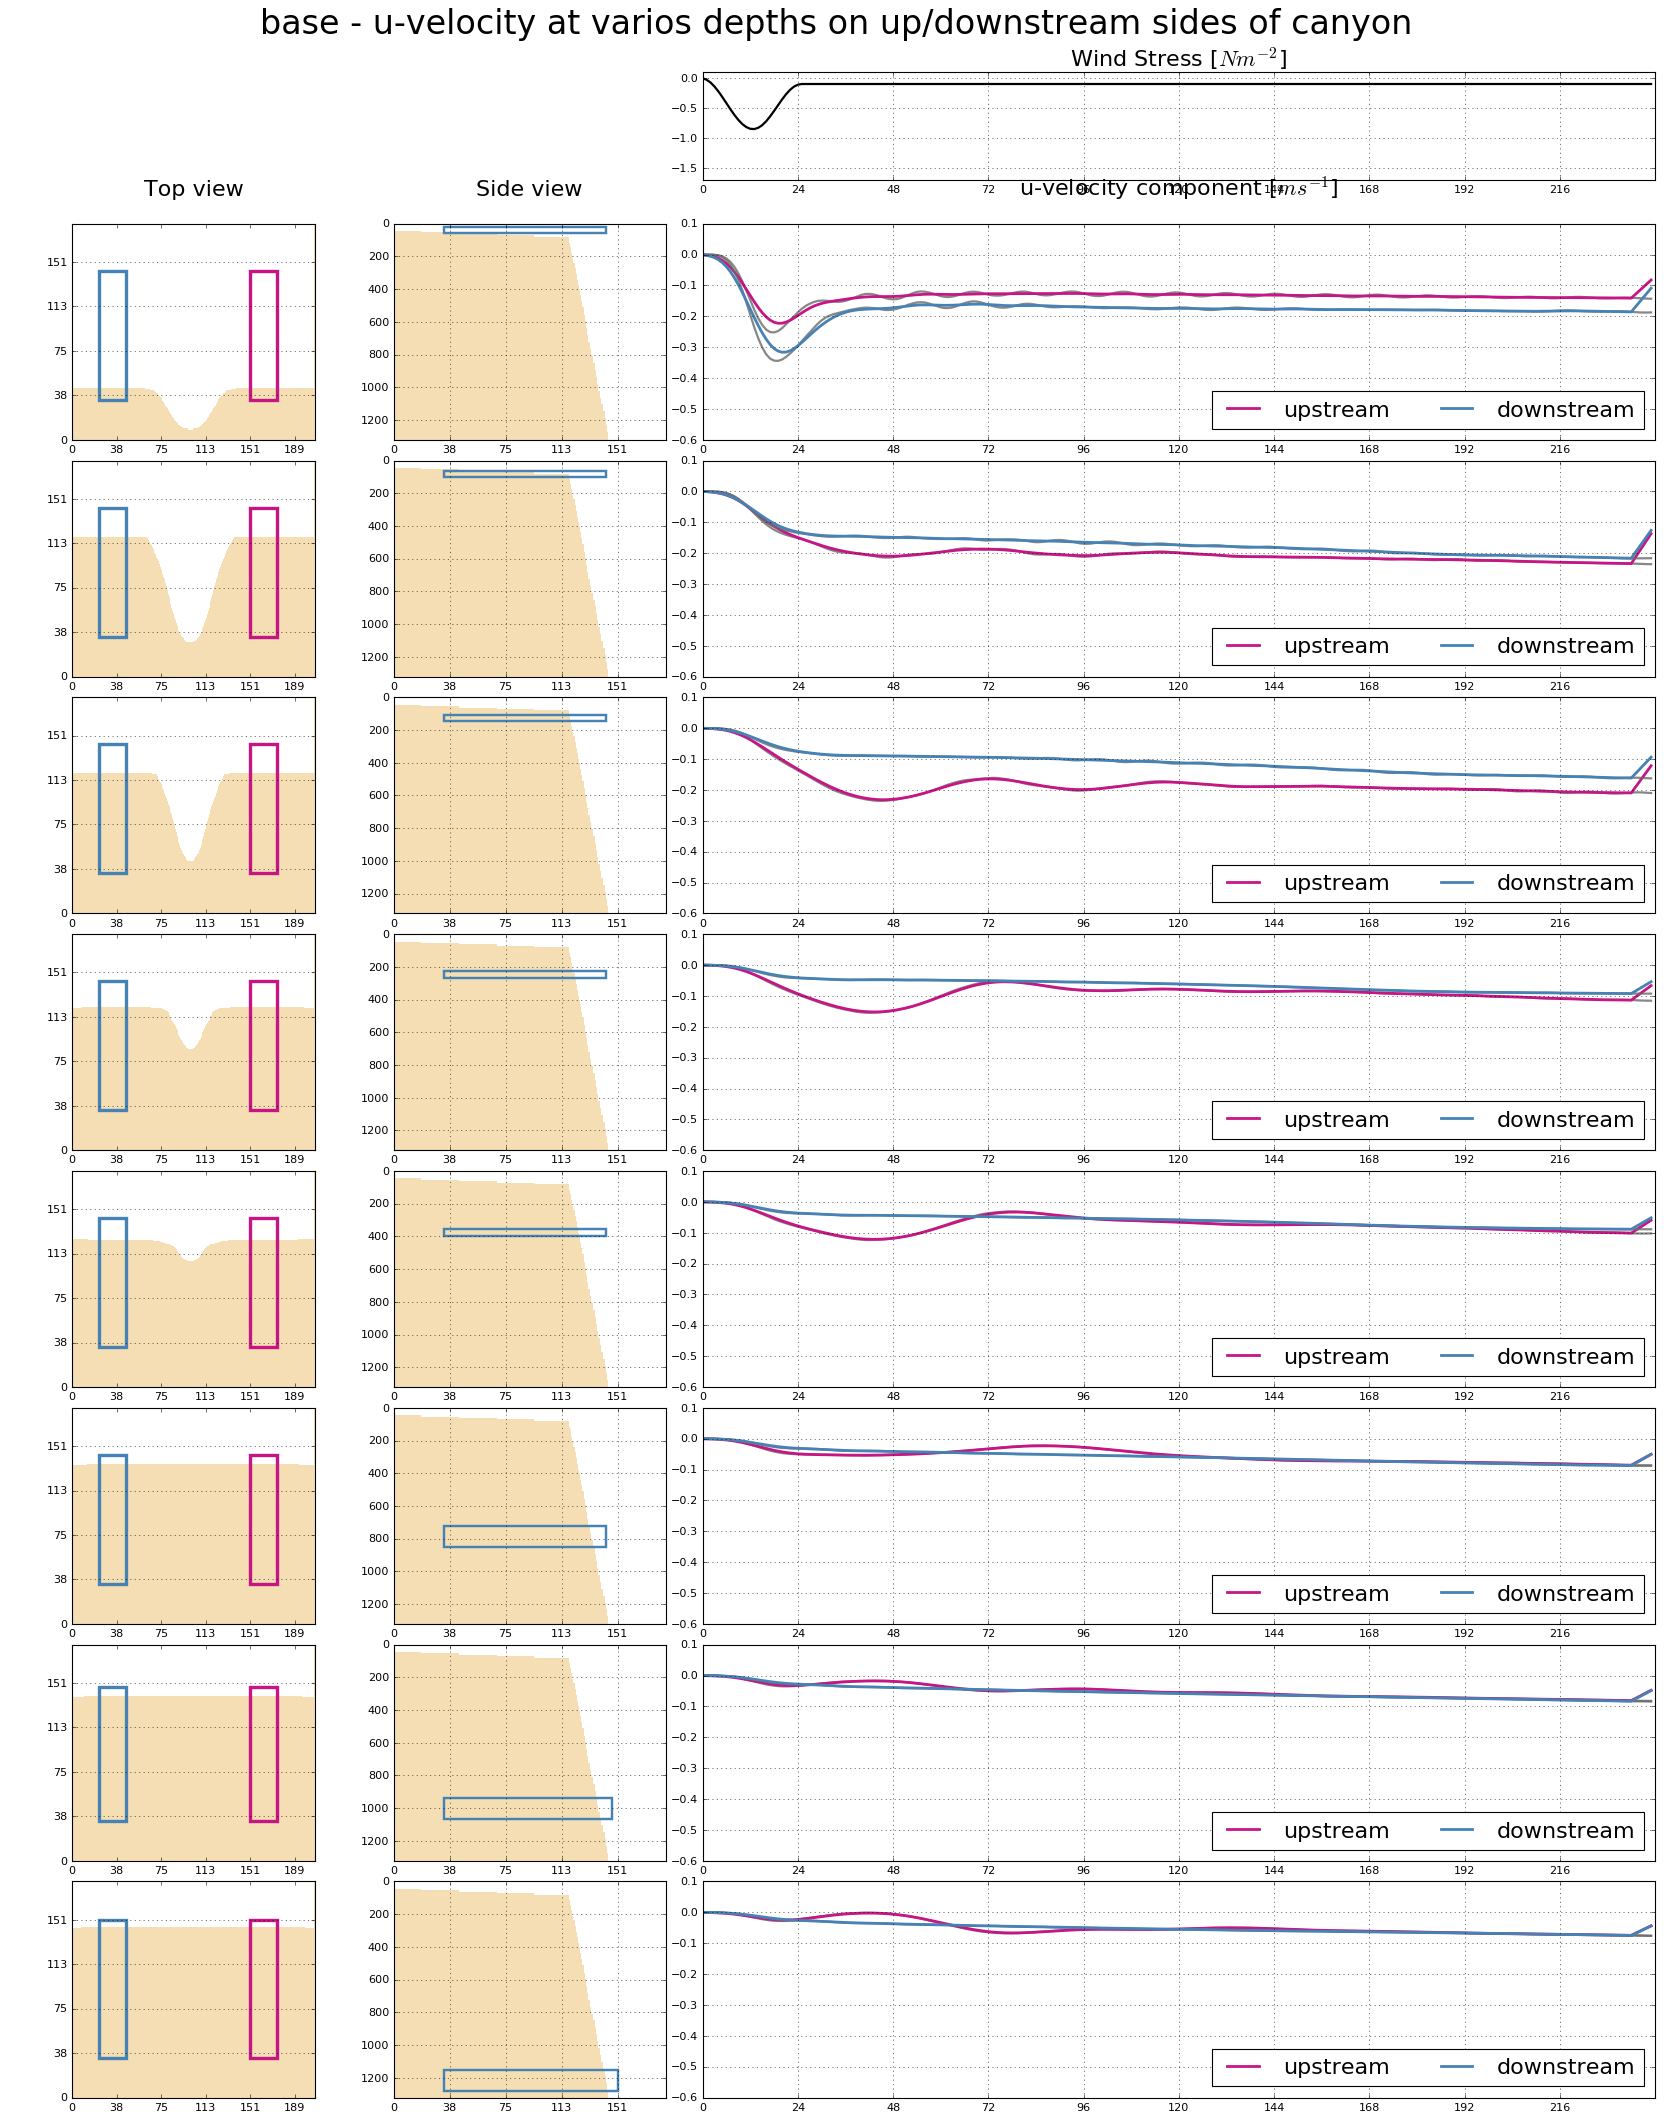

In [84]:
case = 'base'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')

In [ ]:
case = 'half'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')

In [ ]:
case = 'double'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')

# Real

In [25]:
flag = 'real'

In [ ]:
case = 'base'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')

In [ ]:
case = 'half'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')

In [ ]:
case = 'double'
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_'+case+'/'
fig = plot_velocity_boxes(dirname, dicts, case)
fig.savefig('../writing_images/updownstream_uvel_'+case+'_'+flag+'.png', dpi=100, bbox_inches='tight')